In [3]:
from caveclient import CAVEclient, auth
from caveclient import chunkedgraph as cg
import datetime
from itertools import accumulate
import time

In [39]:
global_url = "https://global.brain-wire-test.org/"

# For H01
# url = "https://local.brain-wire-test.org"
# datastack = "h01_c3_flat"
# dataset = "h01_full0_v2"
# group_id = 2 # h01_editors
# proofreading_start = datetime.datetime(2022, 8, 1)

# For Fish1
url = "https://pcgv3local.brain-wire-test.org"
datastack = "fish1_full"
dataset = "fish1_v250117"
group_id = 4 # fish1_editors
proofreading_start = datetime.datetime(2025, 1, 1)

In [35]:
client = CAVEclient(datastack_name=datastack, server_address=global_url)

### Get all user IDs

In [36]:
usr_list = client.auth.get_group_users(group_id=group_id) # get all users in the default group
ids = [item['id'] for item in usr_list]
len(ids)

31

In [37]:
def evenly_spaced_timestamps(start_date, end_date, n):
    time_diff_seconds = (end_date - start_date).total_seconds()
    interval_seconds = time_diff_seconds / (n - 1)
    timestamps = [int(start_date.timestamp()) + i * interval_seconds for i in range(n)]
    return [datetime.datetime.fromtimestamp(val) for val in timestamps]

### Iterate over all users and count number of edits


In [40]:
cggraph = cg.ChunkedGraphClient(server_address=url, table_name=dataset, auth_client=auth.AuthClient(token=client.auth.token))

start = proofreading_start
end = datetime.datetime.now()
interval = 15

total_edits = []
timestamps = evenly_spaced_timestamps(start, end, interval)

for timestamp in timestamps[1:]:
    edits = 0
    for user_id in ids:
        time.sleep(0.5)
        operations = cggraph.get_user_operations(user_id=user_id, timestamp_start=start, timestamp_end=timestamp)
        edits += len(operations)
    total_edits.append(edits)
    start = timestamp

cumulative = list(accumulate(total_edits))

print("Total edits: " + str(total_edits))
print("Cumulative edits: " + str(cumulative))

Total edits: [0, 0, 0, 0, 3792, 16, 2, 0, 0, 0, 0, 0, 0, 0]
Cumulative edits: [0, 0, 0, 0, 3792, 3808, 3810, 3810, 3810, 3810, 3810, 3810, 3810, 3810]


### Plot Results as Line Chart

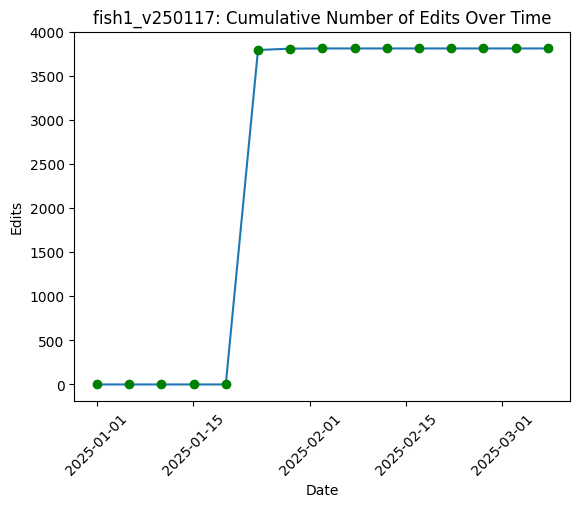

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Date': timestamps, 'Edits': [0] + cumulative})
sns.lineplot(data=df, x='Date', y='Edits')
plt.plot(timestamps, [0] + cumulative, 'go')
plt.xticks(rotation=45)
plt.title('{}: Cumulative Number of Edits Over Time'.format(dataset))
plt.show()